# Теоретическая модель

В данной работе я изучал систему, которая представляет из себя некоторое количество легких частиц растворителя - $\textbf{solvent}$ и тяжелых коллоидных частиц - $\textbf{colloid}$. Я рассматривал, как процентное соотношения тяжелых(коллоидных) частиц влияет на радиальную функцию распределения. Для начала запишем модель, которую мы моделируем, т.е. как взаимодействуют друг с другом коллоидные частицы, частицы растворителя, как взаимодействуют коллоидные частицы с частицами растворителя. Энергия взаимодействия двух коллоидных частиц определяется следующим образом:

$$ U_A = -\dfrac{A_{cc}}{6} \left[ \dfrac{2 a_1 a_2  }{ r^2 - (a_1+a_2)^2} + \dfrac{2 a_1 a_2  }{ r^2 - (a_1-a_2)^2} +  \ln \left( \dfrac{ r^2 - (a_1+a_2)^2}{r^2 - (a_1-a_2)^2} \right) \right]  $$

$$ U_R = \dfrac{A_{cc}}{37800} \dfrac{\sigma^6}{r} \left[ \dfrac{r^2 - 7r(a_1+a_2) + 6(a^2_1 + 7a_1 a_2 +a^2_2)}{(r-a_1-a_2)^7} +  \dfrac{r^2 + 7r(a_1+a_2) + 6(a^2_1 + 7a_1 a_2 +a^2_2)}{(r+a_1+a_2)^7} -    \dfrac{r^2 + 7r(a_1-a_2) + 6(a^2_1 - 7a_1 a_2 +a^2_2)}{(r+a_1-a_2)^7} - \dfrac{r^2 - 7r(a_1-a_2) + 6(a^2_1 - 7a_1 a_2 +a^2_2)}{(r-a_1+a_2)^7} \right]$$ 

$$ U = U_A + U_R \qquad r < r_c $$

Где $ A_{cc} $ - константа Хамакера, $a_1$, $a_2$ - радиусы коллоидных частиц, $\sigma$ - радиус частицы растворителя, $ r_c$ - cutoff. Это уравнение является результатом описания каждой коллоидной частицы как интегрированного набора частиц Леннард-Джонса с размером $\sigma$. 

Взаимодействие colloid-solvent определяется так

$$ U = \dfrac{2a^3 \sigma^3 A_{cs}}{9(a^2-r^2)^3}  \left[ 1 - \dfrac{\left(5a^6 + 45a^4 r^2 + 63 a^2 r^4 + 15 r^6 \right) \sigma^6 }{15 \left(a-r \right)^6(a+r)^6} \right] \qquad r < r_c $$

Где $ A_{cs} $ - константа Хамакера, $a$ - радиус коллоидных частиц, $\sigma$ - радиус частицы растворителя, $ r_c$ - cutoff.  Эта формула выводится из colloid-colloid взаимодействия, устремляя один из радиусов частиц в ноль.

Взаимодействие solvent-solvent определяется просто как потенциал Ленарда - Джонса

$$ U = \dfrac{A_{cc}}{36} \left[ \left( \dfrac{\sigma}{r}  \right)^{12} - \left( \dfrac{\sigma}{r}  \right)^6 \right] \qquad  r < r_c$$

Подробности о теории данной модели(в том числе и вывод) можно найти в Everaers, Ejtehadi, Phys Rev E, 67, 041710 (2003)

# Моделирование

Моделировать данную систему мы будем с помощью пакета $\textbf{LAMMPS}$ под названием $\textbf{COLLOID}$. Параметры запуска находятся в ~/colloid/colloid/in.colloid и выглядят следующим образом


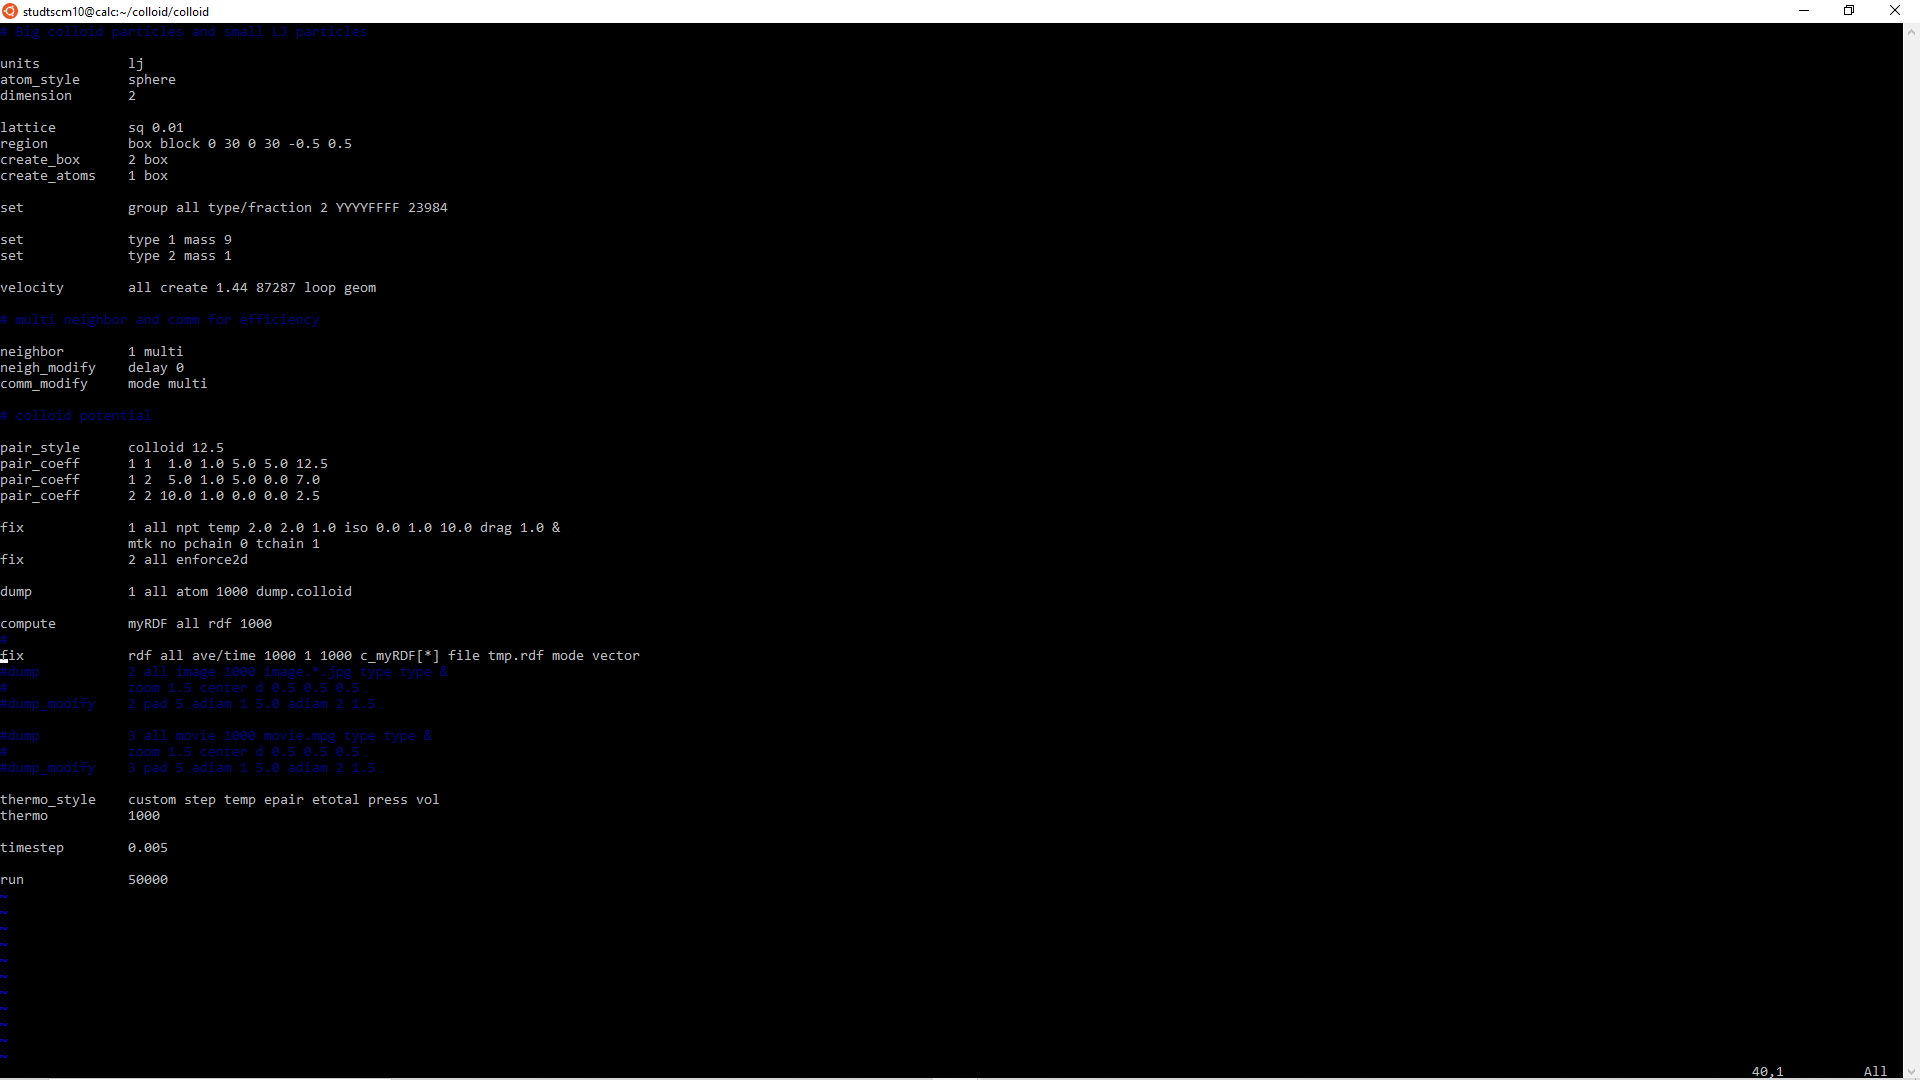

Вместо YYYYFFFF должно быть процентное содержание частиц растворителя. С помощью скрипта $\textbf{start_scriot.sh}$ я в цикле заменяю YYYYFFFF на нужную мне температуру, после чего стартую моделирование системы. На выходе я получаю $\textbf{dump.colloid}$  (используется для визуализации далее) и $ \textbf{tmp.rdf}$  - данные о RDF. Все эти данные хранятся в папке $ \textbf{lj} $. После моделирования, все в том же цикле, я закидываю последние 50 шагов в файл $ \textbf{rdf.txt} $ После выполнения моделирований для разных составов, запускается скрипт $\textbf{gnplot.sh}$, которых строит нам изображение. После чего бот в телеграмме отправляет сообщение о завершение расчетов. Вот что в итоге получено:


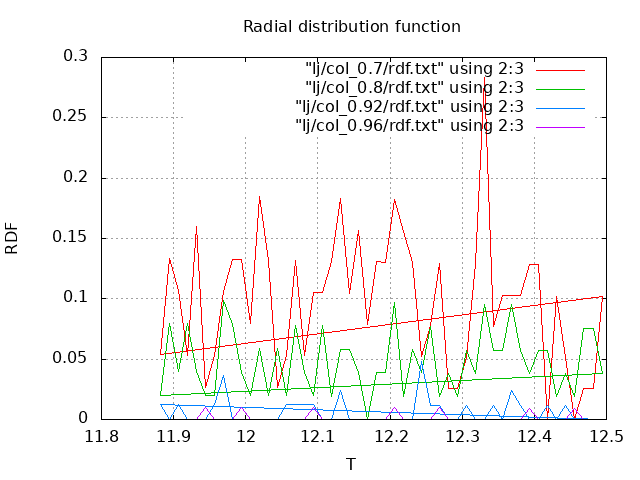!

# Визуализация

В данной части работы я делаю визуализацию данных. Я использую $\textbf{Nglview} $ и $\textbf{Ovito}$. Для начала построим с помощью $\textbf{Nglview}$. На сайте https://wiki.fysik.dtu.dk/ase/ase/io/io.html посмотрим необходимую фунцию, которая сможет считывать выход .dump, который нам дает $\textbf{LAMMPS}$. Нам подходит $\textbf{lammps-dump-text}$. Ниже приведен соответсвующий, честно украденный код. 

In [2]:
import gzip
import struct
from os.path import splitext
from collections import deque
import numpy as np

from ase.visualize import view
from ase.atoms import Atoms
from ase.quaternions import Quaternions
from ase.calculators.singlepoint import SinglePointCalculator
from ase.parallel import paropen
from ase.calculators.lammps import convert


def read_lammps_dump(infileobj, **kwargs):
    """Method which reads a LAMMPS dump file.

       LAMMPS chooses output method depending on the given suffix:
        - .bin  : binary file
        - .gz   : output piped through gzip
        - .mpiio: using mpiio (should be like cleartext,
                  with different ordering)
        - else  : normal clear-text format

    :param infileobj: string to file, opened file or file-like stream

    """
    # !TODO: add support for lammps-regex naming schemes (output per
    # processor and timestep wildcards)

    opened = False
    if isinstance(infileobj, str):
        opened = True
        suffix = splitext(infileobj)[-1]
        if suffix == ".bin":
            fileobj = paropen(infileobj, "rb")
        elif suffix == ".gz":
            # !TODO: save for parallel execution?
            fileobj = gzip.open(infileobj, "rb")
        else:
            fileobj = paropen(infileobj)
    else:
        suffix = splitext(infileobj.name)[-1]
        fileobj = infileobj

    if suffix == ".bin":
        out = read_lammps_dump_binary(fileobj, **kwargs)
        if opened:
            fileobj.close()
        return out

    out = read_lammps_dump_text(fileobj, **kwargs)

    if opened:
        fileobj.close()

    return out


def lammps_data_to_ase_atoms(
    data,
    colnames,
    cell,
    celldisp,
    pbc=False,
    atomsobj=Atoms,
    order=True,
    specorder=None,
    prismobj=None,
    units="metal",
):
    """Extract positions and other per-atom parameters and create Atoms

    :param data: per atom data
    :param colnames: index for data
    :param cell: cell dimensions
    :param celldisp: origin shift
    :param pbc: periodic boundaries
    :param atomsobj: function to create ase-Atoms object
    :param order: sort atoms by id. Might be faster to turn off
    :param specorder: list of species to map lammps types to ase-species
    (usually .dump files to not contain type to species mapping)
    :param prismobj: Coordinate transformation between lammps and ase
    :type prismobj: Prism
    :param units: lammps units for unit transformation between lammps and ase
    :returns: Atoms object
    :rtype: Atoms

    """
    # data array of doubles
    ids = data[:, colnames.index("id")].astype(int)
    types = data[:, colnames.index("type")].astype(int)
    for i in range(0,900):
        if types[i] == 1:
            types[i] = 5
        else:
            types[i] = 9
    if order:
        sort_order = np.argsort(ids)
        ids = ids[sort_order]
        data = data[sort_order, :]
        types = types[sort_order]
        
    # reconstruct types from given specorder
    if specorder:
        types = [specorder[t - 1] for t in types]
    

    def get_quantity(labels, quantity=None):
        try:
            cols = [colnames.index(label) for label in labels]
            if quantity:
                return convert(data[:, cols], quantity, units, "ASE")

            return data[:, cols]
        except ValueError:
            return None

    # slice data block into columns
    # + perform necessary conversions to ASE units
    positions = get_quantity(["x", "y", "z"], "distance")
    scaled_positions = get_quantity(["xs", "ys", "zs"])
    velocities = get_quantity(["vx", "vy", "vz"], "velocity")
    charges = get_quantity(["q"], "charge")
    forces = get_quantity(["fx", "fy", "fz"], "force")
    # !TODO: how need quaternions be converted?
    quaternions = get_quantity(["c_q[1]", "c_q[2]", "c_q[3]", "c_q[4]"])

    # convert cell
    cell = convert(cell, "distance", units, "ASE")
    celldisp = convert(celldisp, "distance", units, "ASE")
    if prismobj:
        celldisp = prismobj.vector_to_ase(celldisp)
        cell = prismobj.update_cell(cell)

    if quaternions:
        out_atoms = Quaternions(
            symbols=types,
            positions=positions,
            cell=cell,
            celldisp=celldisp,
            pbc=pbc,
            quaternions=quaternions,
        )
    elif positions is not None:
        # reverse coordinations transform to lammps system
        # (for all vectors = pos, vel, force)
        if prismobj:
            positions = prismobj.vector_to_ase(positions, wrap=True)

        out_atoms = atomsobj(
            symbols=types,
            positions=positions,
            pbc=pbc,
            celldisp=celldisp,
            cell=cell
        )
    elif scaled_positions is not None:
        out_atoms = atomsobj(
            symbols=types,
            scaled_positions=scaled_positions,
            pbc=pbc,
            celldisp=celldisp,
            cell=cell,
        )

    if velocities is not None:
        if prismobj:
            velocities = prismobj.vector_to_ase(velocities)
        out_atoms.set_velocities(velocities)
    if charges is not None:
        out_atoms.set_initial_charges(charges)
    if forces is not None:
        if prismobj:
            forces = prismobj.vector_to_ase(forces)
        # !TODO: use another calculator if available (or move forces
        #        to atoms.property) (other problem: synchronizing
        #        parallel runs)
        calculator = SinglePointCalculator(out_atoms, energy=0.0, forces=forces)
        out_atoms.calc = calculator

    # process the extra columns of fixes, variables and computes
    #    that can be dumped, add as additional arrays to atoms object
    for colname in colnames:
        # determine if it is a compute or fix (but not the quaternian)
        if (colname.startswith('f_') or colname.startswith('v_') or
                (colname.startswith('c_') and not colname.startswith('c_q['))):
            out_atoms.new_array(colname, get_quantity([colname]), dtype='float')

    return out_atoms


def construct_cell(diagdisp, offdiag):
    """Help function to create an ASE-cell with displacement vector from
    the lammps coordination system parameters.

    :param diagdisp: cell dimension convoluted with the displacement vector
    :param offdiag: off-diagonal cell elements
    :returns: cell and cell displacement vector
    :rtype: tuple
    """
    xlo, xhi, ylo, yhi, zlo, zhi = diagdisp
    xy, xz, yz = offdiag

    # create ase-cell from lammps-box
    xhilo = (xhi - xlo) - abs(xy) - abs(xz)
    yhilo = (yhi - ylo) - abs(yz)
    zhilo = zhi - zlo
    celldispx = xlo - min(0, xy) - min(0, xz)
    celldispy = ylo - min(0, yz)
    celldispz = zlo
    cell = np.array([[xhilo, 0, 0], [xy, yhilo, 0], [xz, yz, zhilo]])
    celldisp = np.array([celldispx, celldispy, celldispz])

    return cell, celldisp


def get_max_index(index):
    if np.isscalar(index):
        return index
    elif isinstance(index, slice):
        return index.stop if (index.stop is not None) else float("inf")


def read_lammps_dump_text(fileobj, index=-1, **kwargs):
    """Process cleartext lammps dumpfiles

    :param fileobj: filestream providing the trajectory data
    :param index: integer or slice object (default: get the last timestep)
    :returns: list of Atoms objects
    :rtype: list
    """
    # Load all dumped timesteps into memory simultaneously
    lines = deque(fileobj.readlines())

    index_end = get_max_index(index)

    n_atoms = 0
    images = []

    while len(lines) > n_atoms:
        line = lines.popleft()

        if "ITEM: TIMESTEP" in line:
            n_atoms = 0
            line = lines.popleft()
            # !TODO: pyflakes complains about this line -> do something
            # ntimestep = int(line.split()[0])  # NOQA

        if "ITEM: NUMBER OF ATOMS" in line:
            line = lines.popleft()
            n_atoms = int(line.split()[0])

        if "ITEM: BOX BOUNDS" in line:
            # save labels behind "ITEM: BOX BOUNDS" in triclinic case
            # (>=lammps-7Jul09)
            # !TODO: handle periodic boundary conditions in tilt_items
            tilt_items = line.split()[3:]
            celldatarows = [lines.popleft() for _ in range(3)]
            celldata = np.loadtxt(celldatarows)
            diagdisp = celldata[:, :2].reshape(6, 1).flatten()

            # determine cell tilt (triclinic case!)
            if len(celldata[0]) > 2:
                # for >=lammps-7Jul09 use labels behind "ITEM: BOX BOUNDS"
                # to assign tilt (vector) elements ...
                offdiag = celldata[:, 2]
                # ... otherwise assume default order in 3rd column
                # (if the latter was present)
                if len(tilt_items) >= 3:
                    sort_index = [tilt_items.index(i)
                                  for i in ["xy", "xz", "yz"]]
                    offdiag = offdiag[sort_index]
            else:
                offdiag = (0.0,) * 3

            cell, celldisp = construct_cell(diagdisp, offdiag)

            # Handle pbc conditions
            if len(tilt_items) > 3:
                pbc = ["p" in d.lower() for d in tilt_items[3:]]
            else:
                pbc = (False,) * 3

        if "ITEM: ATOMS" in line:
            colnames = line.split()[2:]
            datarows = [lines.popleft() for _ in range(n_atoms)]
            data = np.loadtxt(datarows)
            out_atoms = lammps_data_to_ase_atoms(
                data=data,
                colnames=colnames,
                cell=cell,
                celldisp=celldisp,
                atomsobj=Atoms,
                pbc=pbc,
                **kwargs
            )
            images.append(out_atoms)

        if len(images) > index_end >= 0:
            break

    return images[index]



def read_lammps_dump_binary(
    fileobj, index=-1, colnames=None, intformat="SMALLBIG", **kwargs
):
    """Read binary dump-files (after binary2txt.cpp from lammps/tools)

    :param fileobj: file-stream containing the binary lammps data
    :param index: integer or slice object (default: get the last timestep)
    :param colnames: data is columns and identified by a header
    :param intformat: lammps support different integer size.  Parameter set \
    at compile-time and can unfortunately not derived from data file
    :returns: list of Atoms-objects
    :rtype: list
    """
    # depending on the chosen compilation flag lammps uses either normal
    # integers or long long for its id or timestep numbering
    # !TODO: tags are cast to double -> missing/double ids (add check?)
    tagformat, bigformat = dict(
        SMALLSMALL=("i", "i"), SMALLBIG=("i", "q"), BIGBIG=("q", "q")
    )[intformat]

    index_end = get_max_index(index)

    # Standard columns layout from lammpsrun
    if not colnames:
        colnames = ["id", "type", "x", "y", "z",
                    "vx", "vy", "vz", "fx", "fy", "fz"]

    images = []

    # wrap struct.unpack to raise EOFError
    def read_variables(string):
        obj_len = struct.calcsize(string)
        data_obj = fileobj.read(obj_len)
        if obj_len != len(data_obj):
            raise EOFError
        return struct.unpack(string, data_obj)

    while True:
        try:
            # Assume that the binary dump file is in the old (pre-29Oct2020)
            # format
            magic_string = None

            # read header
            ntimestep, = read_variables("=" + bigformat)

            # In the new LAMMPS binary dump format (version 29Oct2020 and
            # onward), a negative timestep is used to indicate that the next
            # few bytes will contain certain metadata
            if ntimestep < 0:
                # First bigint was actually encoding the negative of the format
                # name string length (we call this 'magic_string' to
                magic_string_len = -ntimestep

                # The next `magic_string_len` bytes will hold a string
                # indicating the format of the dump file
                magic_string = b''.join(read_variables("=" +
                    str(magic_string_len) + "c"))

                # Read endianness (integer). For now, we'll disregard the value
                # and simply use the host machine's endianness (via '='
                # character used with struct.calcsize).
                #
                # TODO: Use the endianness of the dump file in subsequent
                #       read_variables rather than just assuming it will match
                #       that of the host
                endian, = read_variables("=i")

                # Read revision number (integer)
                revision, = read_variables("=i")

                # Finally, read the actual timestep (bigint)
                ntimestep, = read_variables("=" + bigformat)

            n_atoms, triclinic = read_variables("=" + bigformat + "i")
            boundary = read_variables("=6i")
            diagdisp = read_variables("=6d")
            if triclinic != 0:
                offdiag = read_variables("=3d")
            else:
                offdiag = (0.0,) * 3
            size_one, = read_variables("=i")

            if len(colnames) != size_one:
                raise ValueError("Provided columns do not match binary file")

            if magic_string and revision > 1:
                # New binary dump format includes units string, columns string, and
                # time
                units_str_len, = read_variables("=i")

                if units_str_len > 0:
                    # Read lammps units style
                    _ = b''.join(read_variables("=" + str(units_str_len) +
                        "c"))

                flag, = read_variables("=c")
                if flag != b'\x00':
                    # Flag was non-empty string
                    time, = read_variables("=d")

                # Length of column string
                columns_str_len, = read_variables("=i")

                # Read column string (e.g., "id type x y z vx vy vz fx fy fz")
                _ = b''.join(read_variables("=" + str(columns_str_len) + "c"))

            nchunk, = read_variables("=i")

            # lammps cells/boxes can have different boundary conditions on each
            # sides (makes mainly sense for different non-periodic conditions
            # (e.g. [f]ixed and [s]hrink for a irradiation simulation))
            # periodic case: b 0 = 'p'
            # non-peridic cases 1: 'f', 2 : 's', 3: 'm'
            pbc = np.sum(np.array(boundary).reshape((3, 2)), axis=1) == 0

            cell, celldisp = construct_cell(diagdisp, offdiag)

            data = []
            for _ in range(nchunk):
                # number-of-data-entries
                n_data, = read_variables("=i")
                # retrieve per atom data
                data += read_variables("=" + str(n_data) + "d")
            data = np.array(data).reshape((-1, size_one))

            # map data-chunk to ase atoms
            out_atoms = lammps_data_to_ase_atoms(
                data=data,
                colnames=colnames,
                cell=cell,
                celldisp=celldisp,
                pbc=pbc,
                **kwargs
            )

            images.append(out_atoms)

            # stop if requested index has been found
            if len(images) > index_end >= 0:
                break

        except EOFError:
            break

    return images[index]

Чтобы показать разницу в размерах частиц, нам необходимо заменить их какими-то другими молекулами, иначе непонятно, какая из молекул является коллоидной. Под комментарием # data array of doubles
мы добавляем вот эти строки:

In [3]:
# data array of doubles
   ids = data[:, colnames.index("id")].astype(int)
    types = data[:, colnames.index("type")].astype(int)
    for i in range(0,900):
        if types[i] == 1:
            types[i] = 5
        else:
            types[i] = 9
# ВЫПОЛНЯТЬ ЭТОТ КОД НЕ НУЖНО

IndentationError: unexpected indent (<ipython-input-3-ead8936a0275>, line 2)

После этого нам осталось лишь визуализировать 

In [4]:
f = open("lj/col_0.96/dump.colloid", "r")
data = read_lammps_dump_text(f, index=slice(None))

In [19]:
from ase.io import write
write('ngl.png', data)

ValueError: png-format can only store 1 Atoms object.

MovieWriter ffmpeg unavailable; using Pillow instead.


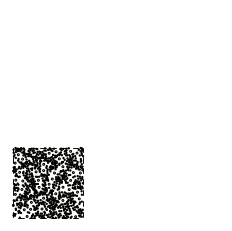

In [23]:
ase.io.animation.write_mp4("a.gif", data)

Видно, как коллоидные частицы образуют некоторые центры, вокруг которых сосредоточены мелкие частички. Это связано с тем, что потенциалы взаимодействия colloid-solvent отличается от solvent-solvent.

In [26]:
import nglview
view(data, viewer='ngl')

In [7]:
import warnings
from typing import Tuple

import numpy as np

from ase import __version__
from ase.calculators.singlepoint import SinglePointCalculator, all_properties
from ase.constraints import dict2constraint
from ase.calculators.calculator import PropertyNotImplementedError
from ase.atoms import Atoms
from ase.io.jsonio import encode, decode
from ase.io.pickletrajectory import PickleTrajectory
from ase.parallel import world
from ase.io.formats import read
import ase.io.trajectory

In [8]:
import nglview as ngl
ngl.show_asetraj(data, gui=True)

NGLWidget(max_frame=50)

In [12]:
import ovito

In [20]:
from ovito.io import import_file
from ovito.vis import ParticlesVis

pipeline = import_file("lj/col_0.96/dump.colloid")
pipeline.add_to_scene()

vis_element = pipeline.source.data.particles.vis
vis_element.shape = ParticlesVis.Shape.Sphere

In [21]:
# Модифицируем нашу загруженную систему
import ovito.modifiers as md
pipeline.add_to_scene()
# Меняем цвет и размер ионов и электронов по RGB.
# (Создаем функцию для замены)
def modifier_color_radius(frame, data):
    color_property = data.particles_.create_property("Color")
    radius_property = data.particles_.create_property("Radius")
    type_property = data.particles['Particle Type']
    transparency_property = data.particles_.create_property("Transparency")
    id_property = data.particles['Particle Identifier']
    # Можем получить кинетическую энергию частиц
    #ke_property = data.particles['c_keatom']
    position_property = data.particles.positions
    for i in range(len(color_property)):
        t = 1/2
        r = 1 - t
        if type_property.array[i] == 1:
            radius_property.marray[i] = 0.9
            transparency_property.marray[i] = 0
            color_property.marray[i] = (t, 0, r)
                
        else:
            radius_property.marray[i] = 0.3
            color_property.marray[i] = (t, 137/255, r)
            transparency_property.marray[i] = 0
# Указываем Ovito какую функцию modifier использовать
pipeline.modifiers.append(
    md.PythonScriptModifier(
        function = modifier_color_radius)
        )
data=pipeline.compute()

In [22]:
# Создаем видео
import math
import ovito.vis as vis
import math
import numpy as np
# Извлекаем размер ячейки
wall=data.cell[0][0]
# Создаем объект визуализации
vp = vis.Viewport()
vp.type = vis.Viewport.Type.Perspective

In [31]:
# Создаем функцию, которая бы по номеру шага выводила бы
# координаты камеры и ее направление
# В окне программы Ovito можно узнать координаты и направление камеры,
# если нажать на настройки отображения.
def get_pos_dir(frame):
    center=np.array([wall/2, wall/2, wall/6])
    direction=np.array([0.5, 0.5, 1])
    position = center + direction
    #direction = [-1,0,-1]
    #position = [34.6, 5.2, 34.6]
    return tuple(position), tuple( (center - position) )
pos, direction = get_pos_dir(0)

In [28]:
# Задаем начальные данные камеры
vp.camera_pos = pos
vp.camera_dir = direction
vp.fov = math.radians(90.0)

In [29]:
# Создаем функцию, которая будет вызываться на каждом шаге
# создания видео и будет вращать нашу камеру
def render_view(args):
    global wall
    frame=args.frame
    #print (args.frame, end=" ")
    logging.info("frame: {:d}".format(args.frame))
    #text1 = "Frame {}".format(args.frame)
    pos, direction = get_pos_dir(frame)
    args.viewport.camera_pos = pos
    args.viewport.camera_dir = direction
    args.viewport.fov = math.radians(90.0)


In [30]:
# Добавляем эту функцию в render
vp.overlays.append(vis.PythonViewportOverlay(function = render_view))

# Можем создать полную анимацию от 0 до 101 шага
# с разрешением 800x400
vp.render_anim(size=(400,300), filename="colloid_0.7_visual.mp4",
    renderer=vis.TachyonRenderer(), range=(0,75))

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined

NameError: name 'logging' is not defined